# Coursework 2 – Machine Learning  
## Image Classification
**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** CMP-X303-0 – Machine Learning   
**Updated:** 23th November 2025  

## Project Overview
The goal of this project is to develop a supervised learning model capable of accurately classifying images into multiple categories. The Intel Image Classification Dataset is used, which contains labeled images of various classes.  

## Importing Libraries
We will use the following libraries for this task:

- **TensorFlow/Keras**: Build and train the neural network.
- **NumPy**: Array manipulation and numerical operations.
- **Matplotlib**: Visualize accuracy, loss, and results.
- **kagglehub**: Download dataset from Kaggle.

If any library is missing, it can be installed using pip.

In [31]:
""" pip command to install above packages for our ML model to run.
Please note TensorFlow will take around 650MB of Storage space. 
Make sure you have sufficient storage before running this notebook
Remove -q argument to see the install progress """

!pip install tensorflow numpy matplotlib kagglehub seaborn

""" If you have Python 3.11 and Intel machine, 
intel extension for tensorflow can be installed that may increase training process in windows machines with intel CPU and iGPUs
Only with Python 3.11 or later

pip install tensorflow==2.12
pip install intel-extension-for-tensorflow[cpu]==1.2.0

"""

' If you have Python 3.11 and Intel machine, \nintel extension for tensorflow can be installed that may increase training process in windows machines with intel CPU and iGPUs\nOnly with Python 3.11 or later\n\npip install tensorflow==2.12\npip install intel-extension-for-tensorflow[cpu]==1.2.0\n\n'

In [32]:
# Import Required Libraries
import os
import shutil

# To download dataset if it does not exist
import kagglehub

# NumPy for numerical and array manipulation
import numpy as np

# Matplotlib for plotting and seaborn for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory


## Loading and Organising Dataset
We use the Intel Image Classification dataset. Kagglehub downloads the dataset to a default cache directory, so we move it to a working directory called `intel-data`.  

In [12]:
# Get currect working directory
current_dir = os.getcwd()

# Define target directory to copy dataset
target_dir = os.path.join(current_dir, "intel-data")

if os.path.exists(target_dir):
    print("Directory already exists. Please Continue below or delete intel-data directory to download data again")
    pass
else:
    
    # Download Intel Image Classification Dataset and capture its path in below variable
    path = kagglehub.dataset_download("puneet6060/intel-image-classification")
    print("Download Path: ", path)

    # Move from cache to target directory
    shutil.move(path, target_dir)
    print("Moved to: ", target_dir)

Directory already exists. Please Continue below or delete intel-data directory to download data again


## Prepare Training and Validation Sets
The `image_dataset_from_directory` utility automatically reads images from folders, assigns labels based on subfolder names, and prepares batches for training.  

- **Training set**: 80% of images used to train the model.
- **Validation set**: 20% of training images used to evaluate model performance during training.
- **Batch size**: 16 images per batch. Can be increase when training for production
- **Image size**: Original stock image sizes are 150x150, with 3 color channels (RGB). We will be downscaling to speedup model training

In [48]:
# Assign global tensorflow seed to change randomness to predictable random number
tf.random.set_seed(1500)
np.random.seed(1500)

# Assign corresponding directories to variables.
train_dir = os.path.join(target_dir, "seg_train/seg_train")

train = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=1500, # Assign any fixed seed to make random deterministic
    image_size=(128,128), # Downscaled
    batch_size=32, # Small batch size to speed up training to test. Increase it to 32 or 64 when training for production
    label_mode='categorical'
)

validation = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=1500, # Assign any fixed seed to make random deterministic
    image_size=(128,128), # Downscaled
    batch_size=32, # Small batch size to speed up training to test. Increase it to 32 or 64 when training for production
    label_mode='categorical'
)

num_classes = len(train.class_names)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


## Convolutional Neural Network (CNN) Architecture
The CNN consists of:

1. **Input Layer**: Accept Downscaled labels
2. **Conv2D + MaxPooling Layers**: Extract features from images.
3. **Flatten Layer**: Converts 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with specified number of neurons.
5. **Dropout Layer**: To prevent overfitting. Enable it when using large number of neurons
6. **Output Layer**: Specify number of classes, with softmax activation for multi-class classification.

This model is suitable for extracting patterns from images and making predictions.

In [22]:
# Randomize image to improve generalization. 
# Use it when training with large batches and epochs for it to be effective
# Please note that augmentation affected by global seed set above.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Sequential Model is used 
model = Sequential([
    # Specifies downscaled input 128x128, 3 channels. Means 3 channel colors RGB
    Input(shape=(128,128,3)),

    # Wrap Data augmentation in model input.
    # Please uncomment below to enable augmentation and only enable it when training full dataset and on large epochs
    # data_augmentation,

    # First convolution block, uses activation Rectified Linear Unit. Applies 32 filters, 3x3 pixel
    Conv2D(32, (3,3), activation='relu'),
    # Get Stronges pixels 2x2
    MaxPooling2D(2,2),
    
    # Second Convolution block with 64 filters applied
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # 3rd convolution block with 128 filters applied
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Turns 2D image into 1D vector. Gets feature maps created by MaxPooling and turns it into 1D long vector
    Flatten(),

    # Fully connected Layer with neurons. Decision making layer. Increase number of neurons when on large epochs
    Dense(64, activation='relu'),

    # Disables given amount of neurons to prevent model overfitting
    # Uncomment below when on large neurons to drop
    #Dropout(0.2),

    # Output layer. gives prediction using softmax to 6 classes (num_classes) defined above
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,334 (6.48 MB)

 Trainable params: 1,699,334 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model
- **Optimizer**: Adam optimizer for efficient gradient descent.
- **Loss function**: Categorical crossentropy for multi-class classification.
- **Metrics**: Accuracy to monitor model performance.

We train the model for 8 epochs with the training and validation datasets.

In [24]:
# Only for testing purposes. Please Comment below lines when training on full dataset
#small_train = train.take(80)
#small_val = validation.take(10)

# Compile model. Uses adam optimizer and tries to minimize loss categorical_crossentropy
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)

# When training on full dataset replace small_train with train and 
# small_val with validation to feed model with full dataset split
history = model.fit(
train,
validation_data=validation,
epochs=8
)

Epoch 1/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.8267 - loss: 0.4764 - val_accuracy: 0.6614 - val_loss: 1.2925
Epoch 2/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.8699 - loss: 0.3669 - val_accuracy: 0.6885 - val_loss: 1.3927
Epoch 3/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.8899 - loss: 0.3187 - val_accuracy: 0.6867 - val_loss: 1.3637
Epoch 4/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.9167 - loss: 0.2523 - val_accuracy: 0.6924 - val_loss: 1.4788
Epoch 5/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.9271 - loss: 0.2098 - val_accuracy: 0.6750 - val_loss: 2.0208
Epoch 6/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.9269 - loss: 0.2187 - val_accuracy: 0.7053 - val_loss: 1.7489
Epoch 7/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.9446 - loss: 0.1673 - val_accuracy: 0.6611 - val_loss: 2.3440
Epoch 8/8
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step - accuracy: 0.9592 - loss: 0.1212 - 

## Model Evaluation
We evaluate the model using:

**Accuracy and Loss Plots**: Shows training vs validation performance over epochs.

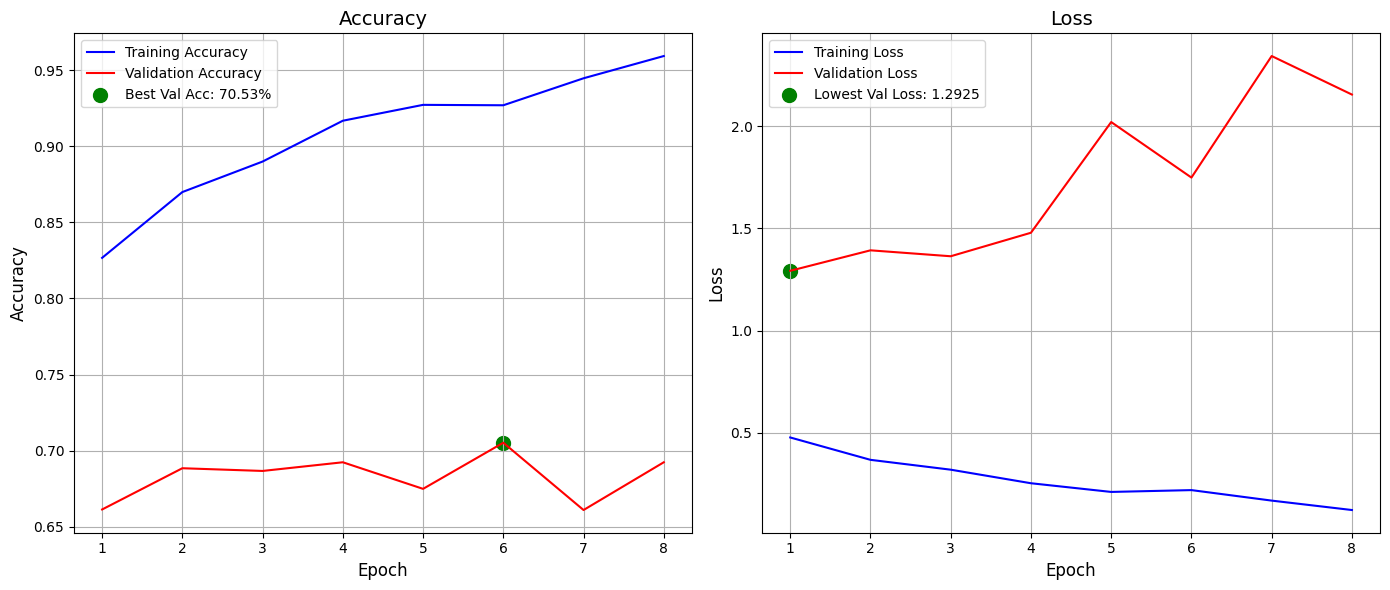

In [27]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

# Create Plot
plt.figure(figsize=(14,6))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.scatter(np.argmax(val_acc)+1, max(val_acc), color='green', 
            s=100, label=f'Best Val Acc: {max(val_acc):.2%}')
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.scatter(np.argmin(val_loss)+1, min(val_loss), color='green', 
            s=100, label=f'Lowest Val Loss: {min(val_loss):.4f}')
plt.title('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(epochs)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Confusion Matrix**: Illustrates correct vs incorrect predictions for each class.

In [51]:
# Collect all images and labels from validation dataset
x_val = np.concatenate([x.numpy() for x, y in validation], axis=0)
y_val = np.concatenate([y.numpy() for x, y in validation], axis=0)

# Predict
y_pred = np.argmax(model.predict(x_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred)
print(conf_matrix)
"""plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
"""

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
tf.Tensor(
[[ 79  71  76  96  42  79]
 [ 86  80  65 104  37  77]
 [ 86  69  81 106  59  87]
 [ 95 102  69  96  57  80]
 [ 80  62  79  97  58  80]
 [ 89  70  85  96  48  83]], shape=(6, 6), dtype=int32)


"plt.figure(figsize=(4,3))\nsns.heatmap(conf_matrix.numpy(), annot=True, fmt='d', cmap='coolwarm')\nplt.xlabel('Predicted')\nplt.ylabel('True')\nplt.title('Confusion Matrix')\nplt.show()\n"

In [17]:
# Load test dataset
test_dir = os.path.join(target_dir, "seg_test/seg_test")
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    batch_size=32,
    label_mode='categorical'
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Found 3000 files belonging to 6 classes.
Classes in test dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
94/94 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.5313 - loss: 1.2040
Test Accuracy: 53.13%
